# Задание на лабораторную работу
## Создать вариационный автоэнкодер с использованием сверток (Conv2d) в энкодере (слои отвечающие за среднее и отклонение остаются полносвязными), и с развертками (Conv2dTranspose) в декодере. Размерность скрытого вектора равна двум

## Создать сетку из 25 изображений, где по оси Х изменяется значение первого элемента z, а по оси Y - второго элемента z 

# Выполнение лабораторной работы

### Иморт необходимых библиотек

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!pip3 install -q imageio
import PIL
import imageio

In [2]:
import numpy as np
np.set_printoptions(linewidth=110)

In [3]:
from packaging import version
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import time
                                      
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.1.0


### Подготовка датасета МНИСТ
- разделение на тестовую и обучающую выборку
- нормализация изображений
- нарезка на части

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

TRAIN_BUF = 60000
BATCH_SIZE = 32

TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

### Код энкодера-декодера

In [5]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                  # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
              tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
          # No activation
              tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    def image_grid(self, z):
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

### Вычисление и применение градиентов

In [6]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Установка количества эпох, измерения, количества необходимых примеров

In [7]:
epochs = 40
latent_dim = 2
num_examples_to_generate = 16

#начальный случайный вектор для генерации
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

### Функция для сохранения и вывода 16 изображений в каждой эпохе

In [8]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(5,5))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Обучение модели

Epoch: 1, Test set ELBO: -179.15103149414062, time elapse for current epoch 37.736247062683105


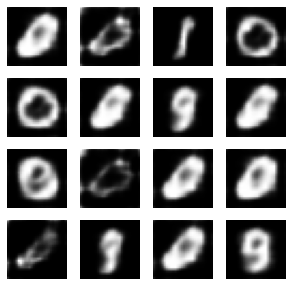

Epoch: 40, Test set ELBO: -150.9443359375, time elapse for current epoch 47.57898497581482


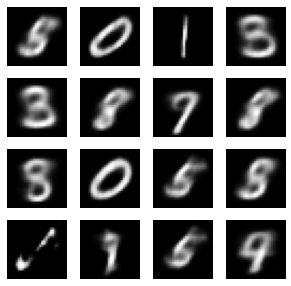

In [9]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        
        if epoch==1 or epoch==epochs:
            print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
            generate_and_save_images(model, epoch, random_vector_for_generation)

### Изображение, которое получилось на 40-ой эпохе

In [10]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 359.5, 359.5, -0.5)

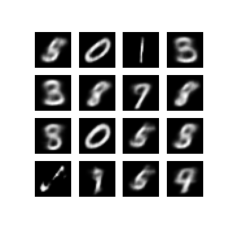

In [11]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### Создание gif из картинок с эпохами

In [12]:
import glob
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

from IPython import display
import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

**Гифка лежит в папке с лабой**

### Функция для вывода сетки изображений с варьируемым параметром

In [13]:
n = 25
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)
def generate_images(model, epoch, writer):
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = model.sample(z_sample).numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j+1) * digit_size] = digit
    
    with writer.as_default():
        image = np.reshape(figure, (1, digit_size*n, digit_size*n, 1))
        tf.summary.image("GEN DATA", image, step=epoch)
    
    plot_image(figure)
    
def plot_image(figure):
    plt.figure(figsize=(n //2, n//2))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.xticks(pixel_range, sample_range_y)
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

### Получившаяся сетка с изображениями


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



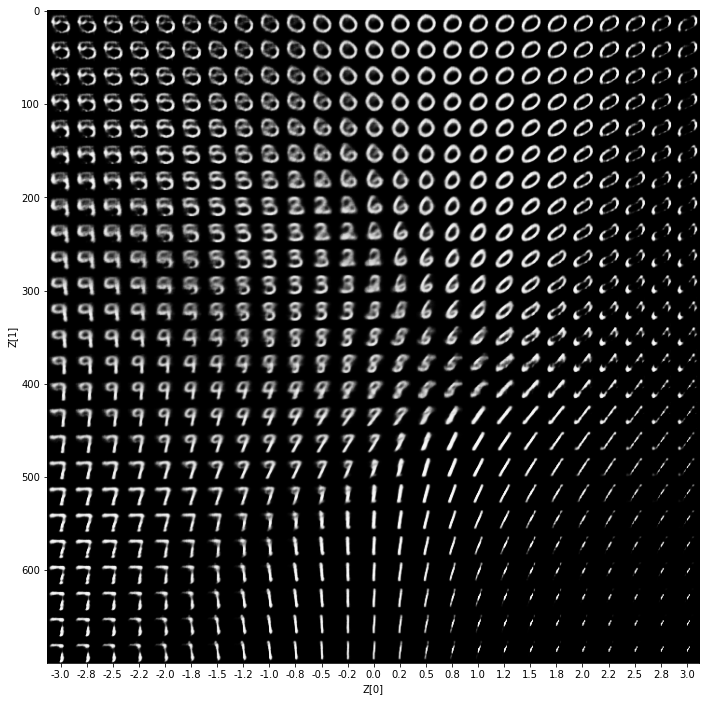

In [14]:
test_summary_writer = tf.summary.create_file_writer("./TEST")
generate_images(model, 40, test_summary_writer)

# Вывод.
В ходе данной лабораторной работы написали вариационный автоэнкодер со сверточными слоями, убедились в его работоспособности

# Контрольные вопросы
1. Что такое автоэнкодер и почему он вариационный?
Автоэнкодер - нейронная сеть, которая сжимает входные данные, а затем восстанавливают из данного представления выходные. НУжно получить наиболее близкий отклик к исходному.
Нужны для снижения размерности или уменьшения шума.  
В вариационном энкодере предполагается, что данные характеризуются вектором переменных, принадлежащих некоторому распределению. И если мы будем знать распределение, то сможем генерировать данные из этого вектора z.

2. В чем отличие оптимизаторов SGD и Adam?
SGD - стохастический градиентный спуск. Выполняется градиентный спуск на небольшом подмножестве или случайной выборке данных. У него маленькая скорость к минимуму. И не очень понятно, как хорошо разбивать данные. Adam следит за скользящим средним градиентов и квадратов градиентов штрафной функции. Это изменяем скорость обучение, поэтому алгоритм сходится нормально

# Список литературы
[1] Google. Tensorflow. 2018. Feb. url - https://www.tensorflow.org/install/install_windows.    
[2] url - https://virtualenv.pypa.io/en/stable/userguide/.    
[3] Microsoft. about_Execution_Policies. 2018. url - https://technet.microsoft.com/en- us/library/dd347641.aspx.   
[4] Jupyter Project. Installing Jupyter. 2018. url - http://jupyter.org/install.   